In [1]:
# %%
# Run this once if the packages are not installed yet
# !pip install pillow pandas matplotlib torch torchvision torchaudio

In [2]:
# %%
import os
import re
import glob
import tarfile
import csv
import math
from typing import List, Tuple

from PIL import Image

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
from tqdm.auto import tqdm

# Matches grayscale  "1x1", "32x18"
# and color pixels   "1x1_r", "1x1_g", "1x1_b"
PIXEL_RE = re.compile(r"^\d+x\d+(?:_[rgb])?$")

# Filename pattern for Edinburgh frames
FILENAME_RE = re.compile(
    r"inspacecam163_(\d{4})_(\d{2})_(\d{2})_(\d{2})_(\d{2})_(\d{2})\.jpg$"
)

In [3]:
# %%
def parse_time_from_filename(name):
    """Returns (hour, minute, second) or None if the filename does not match."""
    base = os.path.basename(name)
    m = FILENAME_RE.match(base)
    if not m:
        return None
    h = int(m.group(4))
    m_ = int(m.group(5))
    s = int(m.group(6))
    return h, m_, s


def seconds_since_midnight(h, m, s):
    return h * 3600 + m * 60 + s


def parse_time_string(s):
    """
    Parse HH:MM or HH:MM:SS -> seconds since midnight.
    """
    parts = s.split(":")
    if len(parts) == 2:
        h, m = parts
        s_val = 0
    elif len(parts) == 3:
        h, m, s_val = parts
    else:
        raise ValueError(f"Invalid time format: {s!r}. Expected HH:MM or HH:MM:SS")
    h_i = int(h)
    m_i = int(m)
    s_i = int(s_val)
    if not (0 <= h_i < 24 and 0 <= m_i < 60 and 0 <= s_i < 60):
        raise ValueError(f"Time out of range: {s!r}")
    return seconds_since_midnight(h_i, m_i, s_i)


def time_filter(day_sec, start_sec, end_sec, use_all_times):
    if use_all_times:
        return True
    return start_sec <= day_sec <= end_sec

In [4]:
# %%
def list_tar_files(folder):
    pattern = os.path.join(folder, "day_*.tar")
    tar_paths = sorted(glob.glob(pattern))
    if not tar_paths:
        raise SystemExit(f"No tar files matching 'day_*.tar' found in {folder}")
    return tar_paths


def first_pass_lengths(tar_paths, start_sec, end_sec, use_all_times, frame_step):
    """
    First pass: determine, for each tar, how many kept frames (after subsampling)
    fall into the specified time window (or all times if use_all_times is True).

    Returns:
      - line_index_by_path: {tar_path -> line_id}
      - line_length_by_path: {tar_path -> number_of_kept_frames}
      - global_max_step: maximum step index across all lines
    """
    line_index_by_path = {}
    line_length_by_path = {}
    line_lengths = []

    line_counter = 0

    for path in tqdm(tar_paths, desc="First pass: counting frames"):
        with tarfile.open(path, "r") as tar:
            times = []
            for member in tar.getmembers():
                if not member.isfile():
                    continue
                t = parse_time_from_filename(member.name)
                if t is None:
                    continue
                h, m, s = t
                day_sec = seconds_since_midnight(h, m, s)
                if time_filter(day_sec, start_sec, end_sec, use_all_times):
                    times.append(day_sec)

        times.sort()
        if times:
            kept_len = (len(times) + frame_step - 1) // frame_step
            line_index_by_path[path] = line_counter
            line_length_by_path[path] = kept_len
            line_lengths.append(kept_len)
            line_counter += 1

    if not line_lengths:
        raise SystemExit("No frames found in the specified time window.")

    max_len = max(line_lengths)
    global_max_step = max_len - 1 if max_len > 1 else 0

    return line_index_by_path, line_length_by_path, global_max_step


In [5]:
# %%
def build_header(width, height, grayscale):
    header = [
        "id",
        "line",
        "label",
        "step",
        "daytimestamp",
        "daytime",
        "action",
        "age",
        "age_global",
    ]
    # Pixel columns; grayscale: <x>x<y>
    # Color: <x>x<y>_r, <x>x<y>_g, <x>x<y>_b
    for x in range(1, width + 1):
        for y in range(1, height + 1):
            if grayscale:
                header.append(f"{x}x{y}")
            else:
                header.append(f"{x}x{y}_r")
                header.append(f"{x}x{y}_g")
                header.append(f"{x}x{y}_b")
    return header


def extract_pixels(img_fileobj, width, height, grayscale):
    """
    Open image, convert to target mode and size, and return a flat list of values.
    Grayscale: one value per pixel.
    Color: three values (R, G, B) per pixel.

    Pixel order matches the original implementation:
    outer loop over x (0..width-1), inner loop over y (0..height-1).
    """
    with Image.open(img_fileobj) as img:
        if grayscale:
            img = img.convert("L")
        else:
            img = img.convert("RGB")
        img = img.resize((width, height), resample=Image.BILINEAR)

        arr = np.asarray(img, dtype=np.uint8)

        if grayscale:
            # arr shape: (height, width)
            # Original order: for x in range(width) for y in range(height): pixels[x,y]
            # That corresponds to arr.T flattened row-major.
            return arr.T.reshape(-1).tolist()
        else:
            # arr shape: (height, width, 3)
            # Want order: x outer, y inner, then (r,g,b) per pixel.
            arr = arr.transpose(1, 0, 2)   # (width, height, 3)
            return arr.reshape(-1, 3).reshape(-1).tolist()

In [6]:
# %%
def second_pass_write_csv(
    tar_paths,
    line_index_by_path,
    line_length_by_path,
    global_max_step,
    start_sec,
    end_sec,
    use_all_times,
    frame_step,
    width,
    height,
    grayscale,
    output_path,
):
    header = build_header(width, height, grayscale)
    global_id = 0
    total_rows = 0

    # Total number of frames to be written, for progress bar
    total_to_write = sum(line_length_by_path.values())

    with open(output_path, "w", newline="") as f:
        writer = csv.writer(f)
        writer.writerow(header)

        with tqdm(total=total_to_write, desc="Second pass: writing CSV") as pbar:
            for path in tar_paths:
                if path not in line_index_by_path:
                    continue  # no frames in window

                line_id = line_index_by_path[path]
                line_len = line_length_by_path[path]

                frames = []
                with tarfile.open(path, "r") as tar:
                    for member in tar.getmembers():
                        if not member.isfile():
                            continue
                        t = parse_time_from_filename(member.name)
                        if t is None:
                            continue
                        h, m, s = t
                        day_sec = seconds_since_midnight(h, m, s)
                        if not time_filter(day_sec, start_sec, end_sec, use_all_times):
                            continue
                        time_str = f"{h:02d}:{m:02d}:{s:02d}"
                        frames.append((day_sec, time_str, member))

                    frames.sort(key=lambda x: x[0])
                    frames = frames[::frame_step]

                    for step, (day_sec, time_str, member) in enumerate(frames):
                        if line_len > 1:
                            age = step / (line_len - 1)
                        else:
                            age = 0.0

                        if global_max_step > 0:
                            age_global = step / global_max_step
                        else:
                            age_global = 0.0

                        img_fileobj = tar.extractfile(member)
                        if img_fileobj is None:
                            continue

                        pixel_values = extract_pixels(
                            img_fileobj,
                            width=width,
                            height=height,
                            grayscale=grayscale,
                        )

                        row = [
                            global_id,          # id
                            line_id,            # line (trajectory/day id)
                            "",                 # label
                            step,               # step
                            day_sec,            # daytimestamp
                            time_str,           # daytime
                            "",                 # action
                            f"{age:.6f}",       # age
                            f"{age_global:.6f}" # age_global
                        ] + pixel_values

                        writer.writerow(row)
                        global_id += 1
                        total_rows += 1
                        pbar.update(1)

    print(f"Wrote {total_rows} rows to {output_path}")


In [7]:
# %%
def make_trajectory_filename(
    output_dir,
    width,
    height,
    grayscale,
    use_all_times,
    start_time,
    end_time,
    frame_step,
):
    """
    Create a unique filename for trajectories based on key parameters.
    """
    mode = "gray" if grayscale else "rgb"
    if use_all_times:
        tw = "all"
    else:
        tw = f"{start_time.replace(':','')}-{end_time.replace(':','')}"
    name = f"trajectories_w{width}h{height}_{mode}_tw{tw}_step{frame_step}.csv"
    return os.path.join(output_dir, name)


def build_trajectories_csv(
    folder,
    output_dir=".",
    output_path=None,
    width=128,
    height=72,
    grayscale=True,
    start_time="15:00:00",
    end_time="15:09:59",
    use_all_times=False,
    frame_step=1,
    target_max_samples=None,
):
    """
    Build trajectory CSV from Edinburgh office monitoring tar files.

    Each row = one frame (downsampled image).
    'line' encodes the day/trajectory id, 'step' encodes the time order within line.

    If target_max_samples is given (>0) and frame_step == 1,
    frame_step is chosen automatically so that total kept frames
    are <= target_max_samples (uniform subsampling in time).
    """
    if frame_step <= 0:
        raise ValueError("frame_step must be >= 1")

    os.makedirs(output_dir, exist_ok=True)

    tar_paths = list_tar_files(folder)

    if use_all_times:
        start_sec = 0
        end_sec = 24 * 3600 - 1
    else:
        start_sec = parse_time_string(start_time)
        end_sec = parse_time_string(end_time)
        if end_sec < start_sec:
            raise ValueError("end_time must be >= start_time")

    # Auto-determine frame_step from target_max_samples (no randomness)
    if target_max_samples is not None and target_max_samples > 0 and frame_step == 1:
        # First pass with frame_step=1 to get total frame count
        _, line_length_by_path_full, _ = first_pass_lengths(
            tar_paths,
            start_sec,
            end_sec,
            use_all_times,
            frame_step=1,
        )
        total_frames = sum(line_length_by_path_full.values())
        if total_frames == 0:
            raise SystemExit("No frames found in the specified time window.")

        auto_step = max(1, math.ceil(total_frames / target_max_samples))
        frame_step = auto_step

        print(
            f"Auto frame_step={frame_step} based on target_max_samples={target_max_samples} "
            f"(total base frames={total_frames}, "
            f"approx kept={math.ceil(total_frames / frame_step)})"
        )

    # Decide output filename (includes final frame_step)
    if output_path is None:
        output_path = make_trajectory_filename(
            output_dir=output_dir,
            width=width,
            height=height,
            grayscale=grayscale,
            use_all_times=use_all_times,
            start_time=start_time,
            end_time=end_time,
            frame_step=frame_step,
        )
    else:
        out_dir = os.path.dirname(output_path)
        if out_dir:
            os.makedirs(out_dir, exist_ok=True)

    (
        line_index_by_path,
        line_length_by_path,
        global_max_step,
    ) = first_pass_lengths(
        tar_paths,
        start_sec,
        end_sec,
        use_all_times,
        frame_step,
    )

    print(f"Found {len(line_index_by_path)} trajectories (days)")
    print(
        f"Total kept frames={sum(line_length_by_path.values())} "
        f"with frame_step={frame_step}"
    )

    second_pass_write_csv(
        tar_paths,
        line_index_by_path,
        line_length_by_path,
        global_max_step,
        start_sec,
        end_sec,
        use_all_times,
        frame_step,
        width,
        height,
        grayscale,
        output_path,
    )

    return output_path

In [8]:
# %%
# === GLOBAL CONFIG ===
SEED = 0  # kept for compatibility if needed

edinburgh_folder = "."   # <- adjust this path
trajectories_output_dir = "trajectories"
embeddings_output_dir   = "embeddings"

# Time window / resolution settings
width = 128
height = 72
grayscale = True       # False = keep RGB
use_all_times = False   # True = ignore time window
start_time = "15:00:00"
end_time   = "15:09:59"

# Subsampling:
# Option A: manual frame_step (ignored if target_max_samples is set and frame_step==1)
frame_step = 1

# Option B: automatic subsampling to aim for <= target_max_samples total frames
target_max_samples = None   # None to disable auto-selection

os.makedirs(trajectories_output_dir, exist_ok=True)
os.makedirs(embeddings_output_dir, exist_ok=True)

# Determine expected trajectory CSV filename for these settings
traj_csv_path = make_trajectory_filename(
    output_dir=trajectories_output_dir,
    width=width,
    height=height,
    grayscale=grayscale,
    use_all_times=use_all_times,
    start_time=start_time,
    end_time=end_time,
    frame_step=frame_step,
)

if not os.path.exists(traj_csv_path):
    print("Trajectory CSV not found; building it now...")
    traj_csv_path = build_trajectories_csv(
        folder=edinburgh_folder,
        output_dir=trajectories_output_dir,
        output_path=traj_csv_path,
        width=width,
        height=height,
        grayscale=grayscale,
        start_time=start_time,
        end_time=end_time,
        use_all_times=use_all_times,
        frame_step=frame_step,
        target_max_samples=target_max_samples,
    )
else:
    print("Using existing trajectory CSV:", traj_csv_path)

print("Trajectory CSV ready:", traj_csv_path)


Trajectory CSV not found; building it now...


First pass: counting frames:   0%|          | 0/12 [00:00<?, ?it/s]

Found 10 trajectories (days)
Total kept frames=5311 with frame_step=1


Second pass: writing CSV:   0%|          | 0/5311 [00:00<?, ?it/s]

Wrote 5311 rows to trajectories\trajectories_w128h72_gray_tw150000-150959_step1.csv
Trajectory CSV ready: trajectories\trajectories_w128h72_gray_tw150000-150959_step1.csv


In [9]:

# %%
class ConvAutoencoder(nn.Module):
    """
    Convolutional autoencoder with a configurable stack of encoder conv blocks
    and mirrored decoder transposed-conv blocks. Latent space is a vector of size
    `latent_dim` (here typically 2).
    """

    def __init__(
        self,
        in_channels: int,
        img_height: int,
        img_width: int,
        conv_channels: List[int],
        kernel_size: int = 3,
        latent_dim: int = 2,
        dropout: float = 0.0,
    ):
        super().__init__()

        self.in_channels = in_channels
        self.img_h = img_height
        self.img_w = img_width
        self.latent_dim = latent_dim

        padding = kernel_size // 2

        # Encoder
        encoder_layers: List[nn.Module] = []
        c_in = in_channels
        for c_out in conv_channels:
            encoder_layers.append(
                nn.Conv2d(
                    c_in,
                    c_out,
                    kernel_size=kernel_size,
                    stride=2,  # downsample by factor 2
                    padding=padding,
                    bias=False,
                )
            )
            encoder_layers.append(nn.BatchNorm2d(c_out))
            encoder_layers.append(nn.ReLU(inplace=True))
            if dropout > 0.0:
                encoder_layers.append(nn.Dropout2d(p=dropout))
            c_in = c_out
        self.encoder_conv = nn.Sequential(*encoder_layers)

        # Determine shape after encoder convs using a dummy pass
        with torch.no_grad():
            dummy = torch.zeros(1, in_channels, img_height, img_width)
            enc_out = self.encoder_conv(dummy)
        self.enc_out_shape = enc_out.shape[1:]  # (C, H, W)
        enc_flat_dim = int(enc_out.numel() // enc_out.shape[0])

        # Linear layers for latent code
        self.fc_enc = nn.Linear(enc_flat_dim, latent_dim)
        self.fc_dec = nn.Linear(latent_dim, enc_flat_dim)

        # Decoder: mirror conv stacks with ConvTranspose2d
        decoder_layers: List[nn.Module] = []
        rev_channels = list(reversed(conv_channels))
        for i, c_in_dec in enumerate(rev_channels):
            if i + 1 < len(rev_channels):
                c_out_dec = rev_channels[i + 1]
                final = False
            else:
                c_out_dec = in_channels
                final = True

            # stride=2, padding=1, output_padding=1 yields exact doubling in size
            decoder_layers.append(
                nn.ConvTranspose2d(
                    c_in_dec,
                    c_out_dec,
                    kernel_size=kernel_size,
                    stride=2,
                    padding=padding,
                    output_padding=1,
                    bias=False,
                )
            )

            if not final:
                decoder_layers.append(nn.BatchNorm2d(c_out_dec))
                decoder_layers.append(nn.ReLU(inplace=True))
            else:
                # Map back to [0,1] for normalized intensities
                decoder_layers.append(nn.Sigmoid())

        self.decoder_conv = nn.Sequential(*decoder_layers)

        # Sanity check: confirm output shape matches input shape
        with torch.no_grad():
            x = torch.zeros(1, in_channels, img_height, img_width)
            recon = self.forward(x)[0]
        if recon.shape != x.shape:
            raise RuntimeError(
                f"Autoencoder output shape {recon.shape} does not match input shape {x.shape}. "
                f"Adjust conv configuration."
            )

    def encode(self, x: torch.Tensor) -> torch.Tensor:
        h = self.encoder_conv(x)
        h = h.view(h.size(0), -1)
        z = self.fc_enc(h)
        return z

    def decode(self, z: torch.Tensor) -> torch.Tensor:
        h = self.fc_dec(z)
        h = h.view(z.size(0), *self.enc_out_shape)
        x_recon = self.decoder_conv(h)
        return x_recon

    def forward(self, x: torch.Tensor):
        z = self.encode(x)
        x_recon = self.decode(z)
        return x_recon, z



In [10]:
# %%
# Load trained autoencoder model and config from checkpoint
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

model_ckpt_path = os.path.join(
    "autoencoder_runs",
    "ae_edinburgh-office-data_w128h72_gray_twall_step1_ae_cnn_ep=50_seed0.pt",
)

checkpoint = torch.load(model_ckpt_path, map_location=device)

if "config" not in checkpoint:
    raise RuntimeError("Checkpoint does not contain 'config'; cannot reconstruct model.")

ae_config = checkpoint["config"]
model_cfg = ae_config.get("model", {})

in_channels_ae = int(model_cfg.get("in_channels", 1))
img_width_ae = int(model_cfg.get("img_width", width))
img_height_ae = int(model_cfg.get("img_height", height))
conv_channels = [int(c) for c in model_cfg.get("conv_channels", [32, 64, 128])]
kernel_size = int(model_cfg.get("kernel_size", 3))
latent_dim = int(model_cfg.get("latent_dim", 2))
dropout = float(model_cfg.get("dropout", 0.0))

# Consistency checks with current trajectory CSV settings
if grayscale and in_channels_ae != 1:
    raise RuntimeError(
        f"Model expects {in_channels_ae} input channels but grayscale=True (1 channel)."
    )
if (not grayscale) and in_channels_ae != 3:
    raise RuntimeError(
        f"Model expects {in_channels_ae} input channels but grayscale=False (3 channels)."
    )
if img_width_ae != width or img_height_ae != height:
    raise RuntimeError(
        f"Model image size ({img_width_ae}x{img_height_ae}) does not match "
        f"trajectory CSV size ({width}x{height})."
    )

ae_model = ConvAutoencoder(
    in_channels=in_channels_ae,
    img_height=img_height_ae,
    img_width=img_width_ae,
    conv_channels=conv_channels,
    kernel_size=kernel_size,
    latent_dim=latent_dim,
    dropout=dropout,
)

ae_model.load_state_dict(checkpoint["model_state_dict"])
ae_model.to(device)
ae_model.eval()

print("Loaded AE model from:", model_ckpt_path)
print("Latent dim:", latent_dim)



Using device: cuda


C:\Users\Christian\AppData\Local\Temp\ipykernel_3640\823913358.py:11: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(model_ckpt_path, map_location=dev

Loaded AE model from: autoencoder_runs\ae_edinburgh-office-data_w128h72_gray_twall_step1_ae_cnn_ep=50_seed0.pt
Latent dim: 2


In [11]:
# %%
# Load trained autoencoder model and config from checkpoint
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

model_ckpt_path = os.path.join(
    "autoencoder_runs",
    "ae_edinburgh-office-data_w128h72_gray_tw150000-150959_step1_ae_cnn_ep=50_1500-1510_1fps_seed0.pt",
)

checkpoint = torch.load(model_ckpt_path, map_location=device)

if "config" not in checkpoint:
    raise RuntimeError("Checkpoint does not contain 'config'; cannot reconstruct model.")

ae_config = checkpoint["config"]
model_cfg = ae_config.get("model", {})

in_channels_ae = int(model_cfg.get("in_channels", 1))
img_width_ae = int(model_cfg.get("img_width", width))
img_height_ae = int(model_cfg.get("img_height", height))
conv_channels = [int(c) for c in model_cfg.get("conv_channels", [32, 64, 128])]
kernel_size = int(model_cfg.get("kernel_size", 3))
latent_dim = int(model_cfg.get("latent_dim", 2))
dropout = float(model_cfg.get("dropout", 0.0))

# Consistency checks with current trajectory CSV settings
if grayscale and in_channels_ae != 1:
    raise RuntimeError(
        f"Model expects {in_channels_ae} input channels but grayscale=True (1 channel)."
    )
if (not grayscale) and in_channels_ae != 3:
    raise RuntimeError(
        f"Model expects {in_channels_ae} input channels but grayscale=False (3 channels)."
    )
if img_width_ae != width or img_height_ae != height:
    raise RuntimeError(
        f"Model image size ({img_width_ae}x{img_height_ae}) does not match "
        f"trajectory CSV size ({width}x{height})."
    )

ae_model = ConvAutoencoder(
    in_channels=in_channels_ae,
    img_height=img_height_ae,
    img_width=img_width_ae,
    conv_channels=conv_channels,
    kernel_size=kernel_size,
    latent_dim=latent_dim,
    dropout=dropout,
)

ae_model.load_state_dict(checkpoint["model_state_dict"])
ae_model.to(device)
ae_model.eval()

print("Loaded AE model from:", model_ckpt_path)
print("Latent dim:", latent_dim)

Using device: cuda
Loaded AE model from: autoencoder_runs\ae_edinburgh-office-data_w128h72_gray_tw150000-150959_step1_ae_cnn_ep=50_1500-1510_1fps_seed0.pt
Latent dim: 2


C:\Users\Christian\AppData\Local\Temp\ipykernel_3640\1544228526.py:11: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(model_ckpt_path, map_location=de

In [12]:
# %%
# Stream the large trajectory CSV, compute AE latents in batches,
# write a new CSV with x,y appended, and collect data for a scatterplot.

base_traj = os.path.splitext(os.path.basename(traj_csv_path))[0]
ae_csv_path = os.path.join(
    embeddings_output_dir,
    f"{base_traj}_ae_latent.csv",
)

print("Streaming AE embedding from:", traj_csv_path)
print("Writing augmented CSV to:", ae_csv_path)

batch_size = 1024*4

lines_for_plot: List[int] = []
xs_for_plot: List[float] = []
ys_for_plot: List[float] = []

with open(traj_csv_path, "r", newline="") as f_in, open(ae_csv_path, "w", newline="") as f_out:
    reader = csv.reader(f_in)
    writer = csv.writer(f_out)

    # Read header
    header = next(reader)
    # Determine indices for pixel columns and "line"
    pixel_indices = [i for i, col in enumerate(header) if PIXEL_RE.match(col)]
    if not pixel_indices:
        raise SystemExit(
            "No pixel columns found in CSV header; expected names like '1x1', '1x2', or '1x1_r', etc."
        )
    pix_start = min(pixel_indices)
    pix_end = max(pixel_indices) + 1

    try:
        line_idx = header.index("line")
    except ValueError:
        raise SystemExit("Column 'line' not found in CSV header; needed for coloring.")

    # Write new header with x,y appended
    writer.writerow(header + ["x", "y"])

    batch_rows: List[List[str]] = []
    batch_lines: List[int] = []

    for row in tqdm(reader, desc="AE embedding from CSV"):
        if not row:
            continue
        batch_rows.append(row)
        batch_lines.append(int(row[line_idx]))

        if len(batch_rows) >= batch_size:
            # Process current batch
            B = len(batch_rows)
            num_pixels = pix_end - pix_start

            # Build pixel array (B, num_pixels)
            pixels_batch = np.empty((B, num_pixels), dtype=np.float32)
            for i, r in enumerate(batch_rows):
                # Convert pixel strings to integers
                pixels_batch[i, :] = np.fromiter(
                    (int(v) for v in r[pix_start:pix_end]),
                    dtype=np.float32,
                    count=num_pixels,
                )

            if grayscale:
                if num_pixels != width * height:
                    raise RuntimeError(
                        f"Expected {width*height} grayscale pixels, got {num_pixels}."
                    )
                # pixels_batch: (B, W*H) with x-major order
                # Reshape to (B, W, H) then transpose to (B, H, W) to recover original (H,W)
                pixels_batch = pixels_batch.reshape(B, width, height)
                X_images = np.transpose(pixels_batch, (0, 2, 1))  # (B, H, W)
                X_images = X_images[:, np.newaxis, :, :]          # (B, 1, H, W)
            else:
                raise NotImplementedError("RGB trajectories not yet supported for AE embedding.")

            # Normalize to [0,1] as during AE training
            X_images = X_images.astype(np.float32) / 255.0

            with torch.no_grad():
                batch_tensor = torch.from_numpy(X_images).to(device)
                z = ae_model.encode(batch_tensor)   # (B, latent_dim)
                z_np = z.cpu().numpy()

            # Append to plot buffers and write rows with x,y
            xs_for_plot.extend(z_np[:, 0].tolist())
            ys_for_plot.extend(z_np[:, 1].tolist())
            lines_for_plot.extend(batch_lines)

            for r, zx, zy in zip(batch_rows, z_np[:, 0], z_np[:, 1]):
                writer.writerow(r + [float(zx), float(zy)])

            # Reset batch
            batch_rows = []
            batch_lines = []

    # Process any remaining rows
    if batch_rows:
        B = len(batch_rows)
        num_pixels = pix_end - pix_start

        pixels_batch = np.empty((B, num_pixels), dtype=np.float32)
        for i, r in enumerate(batch_rows):
            pixels_batch[i, :] = np.fromiter(
                (int(v) for v in r[pix_start:pix_end]),
                dtype=np.float32,
                count=num_pixels,
            )

        if grayscale:
            if num_pixels != width * height:
                raise RuntimeError(
                    f"Expected {width*height} grayscale pixels, got {num_pixels}."
                )
            pixels_batch = pixels_batch.reshape(B, width, height)
            X_images = np.transpose(pixels_batch, (0, 2, 1))  # (B, H, W)
            X_images = X_images[:, np.newaxis, :, :]          # (B, 1, H, W)
        else:
            raise NotImplementedError("RGB trajectories not yet supported for AE embedding.")

        X_images = X_images.astype(np.float32) / 255.0

        with torch.no_grad():
            batch_tensor = torch.from_numpy(X_images).to(device)
            z = ae_model.encode(batch_tensor)
            z_np = z.cpu().numpy()

        xs_for_plot.extend(z_np[:, 0].tolist())
        ys_for_plot.extend(z_np[:, 1].tolist())
        lines_for_plot.extend(batch_lines)

        for r, zx, zy in zip(batch_rows, z_np[:, 0], z_np[:, 1]):
            writer.writerow(r + [float(zx), float(zy)])

print("Saved AE latent CSV to:", ae_csv_path)
print("Total points embedded:", len(xs_for_plot))

Streaming AE embedding from: trajectories\trajectories_w128h72_gray_tw150000-150959_step1.csv
Writing augmented CSV to: embeddings\trajectories_w128h72_gray_tw150000-150959_step1_ae_latent.csv


AE embedding from CSV: 0it [00:00, ?it/s]

Saved AE latent CSV to: embeddings\trajectories_w128h72_gray_tw150000-150959_step1_ae_latent.csv
Total points embedded: 5311


Saved AE latent scatterplot to: embeddings\trajectories_w128h72_gray_tw150000-150959_step1_ae_latent_scatter.png


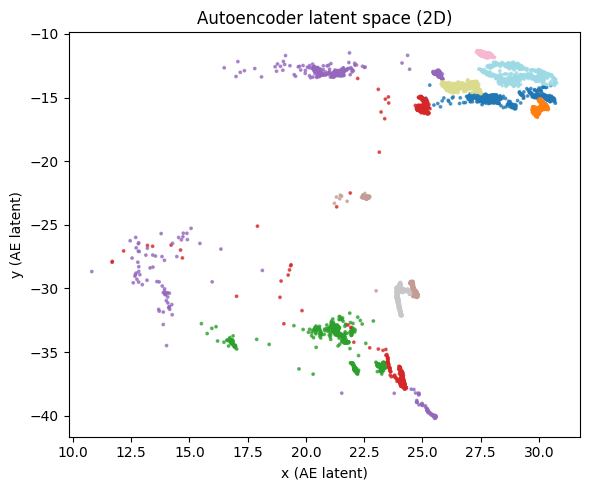

In [13]:
# %%
# Create scatterplot colored by line (trajectory/day id)
lines_array = np.array(lines_for_plot)
xs_array = np.array(xs_for_plot, dtype=np.float32)
ys_array = np.array(ys_for_plot, dtype=np.float32)

cat = pd.Categorical(lines_array)
codes = cat.codes  # 0..K-1

plt.figure(figsize=(6, 5))
plt.scatter(
    xs_array,
    ys_array,
    c=codes,
    s=3,
    alpha=0.7,
    cmap="tab20",
)
plt.xlabel("x (AE latent)")
plt.ylabel("y (AE latent)")
plt.title("Autoencoder latent space (2D)")
plt.tight_layout()

ae_plot_path = os.path.join(
    embeddings_output_dir,
    f"{base_traj}_ae_latent_scatter.png",
)
plt.savefig(ae_plot_path, dpi=300)
print("Saved AE latent scatterplot to:", ae_plot_path)
plt.show()

## Subsample AE-embedded trajectories CSV by time window + frame_step

This cell is self-contained: it can be run in a fresh notebook
to create a new subsampled CSV from a previously saved AE-latent CSV.


In [14]:
# %%
# Subsample AE-embedded trajectories CSV by time window + frame_step
# Streaming version that does not load the entire CSV into memory.

import os
import csv
from typing import Dict
from tqdm.auto import tqdm

def parse_time_string(s: str) -> int:
    """
    Parse HH:MM or HH:MM:SS -> seconds since midnight.
    """
    parts = s.split(":")
    if len(parts) == 2:
        h, m = parts
        s_val = 0
    elif len(parts) == 3:
        h, m, s_val = parts
    else:
        raise ValueError(f"Invalid time format: {s!r}. Expected HH:MM or HH:MM:SS")
    h_i = int(h)
    m_i = int(m)
    s_i = int(s_val)
    if not (0 <= h_i < 24 and 0 <= m_i < 60 and 0 <= s_i < 60):
        raise ValueError(f"Time out of range: {s!r}")
    return h_i * 3600 + m_i * 60 + s_i


# === CONFIG ===
# Path to the full AE-latent CSV created earlier
input_csv_path = os.path.join(
    "embeddings",
    "trajectories_w128h72_gray_twall_step1_ae_latent.csv",  # adjust if needed
)

# Where to write the subsampled CSV
output_dir = "embeddings_subsamples"

# Time window / subsampling settings
use_all_times = True          # True = ignore start_time/end_time and keep all times
start_time    = "00:00:00"     # HH:MM or HH:MM:SS
end_time      = "23:59:59"
frame_step    = 60              # keep every N-th frame per line after time filtering


# === BASIC CHECKS ===
if frame_step <= 0:
    raise ValueError("frame_step must be >= 1")

if not os.path.exists(input_csv_path):
    raise SystemExit(f"Input CSV not found: {input_csv_path}")

if use_all_times:
    tw_str = "all"
else:
    start_sec = parse_time_string(start_time)
    end_sec = parse_time_string(end_time)
    if end_sec < start_sec:
        raise ValueError("end_time must be >= start_time")
    tw_str = f"{start_time.replace(':','')}-{end_time.replace(':','')}"


# === STREAMING SUBSAMPLING ===
os.makedirs(output_dir, exist_ok=True)

base_name = os.path.splitext(os.path.basename(input_csv_path))[0]
out_name  = f"{base_name}_sub_tw{tw_str}_step{frame_step}.csv"
out_path  = os.path.join(output_dir, out_name)

print("Reading from:", input_csv_path)
print("Writing to  :", out_path)

kept_rows = 0
total_rows = 0

# Per-line counters over time-filtered rows only
line_counters: Dict[str, int] = {}

with open(input_csv_path, "r", newline="") as f_in, open(out_path, "w", newline="") as f_out:
    reader = csv.reader(f_in)
    writer = csv.writer(f_out)

    # Header
    try:
        header = next(reader)
    except StopIteration:
        raise SystemExit("Input CSV is empty.")

    # Required indices
    try:
        line_idx = header.index("line")
    except ValueError:
        raise SystemExit("Column 'line' not found in CSV header; needed for per-line subsampling.")

    # Prefer integer daytimestamp if available, otherwise daytime string
    daytimestamp_idx = header.index("daytimestamp") if "daytimestamp" in header else -1
    if daytimestamp_idx == -1:
        daytime_idx = header.index("daytime") if "daytime" in header else -1
        if daytime_idx == -1:
            raise SystemExit("Expected either 'daytimestamp' or 'daytime' column for time filtering.")
    else:
        daytime_idx = -1

    # Write header unchanged
    writer.writerow(header)

    for row in tqdm(reader, desc="Subsampling AE-latent CSV"):
        if not row:
            continue
        total_rows += 1

        line_val = row[line_idx]  # keep as string for dictionary key

        # Time filtering
        if use_all_times:
            time_ok = True
        else:
            if daytimestamp_idx >= 0:
                ts = int(row[daytimestamp_idx])
            else:
                ts = parse_time_string(row[daytime_idx])
            time_ok = (ts >= start_sec) and (ts <= end_sec)

        if not time_ok:
            # Time-filtered out; do not affect frame_step counting within the filtered subset
            continue

        # Per-line index within the time-filtered subset
        idx = line_counters.get(line_val, 0)

        # Keep every N-th row per line
        if idx % frame_step == 0:
            writer.writerow(row)
            kept_rows += 1

        line_counters[line_val] = idx + 1

print(f"Total rows scanned   : {total_rows}")
print(f"Rows kept (subsample): {kept_rows}")

if kept_rows == 0:
    print("No rows remained after filtering and subsampling; removing empty output file.")
    os.remove(out_path)
    raise SystemExit("No rows remained after filtering and subsampling.")
else:
    print("Saved subsampled CSV to:", out_path)


Reading from: embeddings\trajectories_w128h72_gray_twall_step1_ae_latent.csv
Writing to  : embeddings_subsamples\trajectories_w128h72_gray_twall_step1_ae_latent_sub_twall_step60.csv


Subsampling AE-latent CSV: 0it [00:00, ?it/s]

Total rows scanned   : 12288
Rows kept (subsample): 206
Saved subsampled CSV to: embeddings_subsamples\trajectories_w128h72_gray_twall_step1_ae_latent_sub_twall_step60.csv
